# DAViT

## Import Libraries

In [1]:
import os
import sys
import datetime
import random
import numpy as np
import pandas as pd

import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 
from torch import einsum

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from matplotlib import pyplot as plt 

from torchsummary import summary

## Utilities

In [2]:
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## Define Super-parameters

In [3]:
seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# about the data set
train_path = '/global/cfs/cdirs/m3691/data/office/amazon/images'
valid_path = '/global/cfs/cdirs/m3691/data/office/dslr/images'
channels = 3
image_size = 28
num_classes = 10

# about the data loader
batch_size = 128
num_workers = 8

# about the model
patch_size = 7
patch_side = image_size // patch_size
num_patches = patch_side * patch_side
dim = 512
depth = 4
heads = 8
mlp_dim = 1024
emb_dropout = 0.1
dropout = 0.1

# about the optimizer
lr = 1e-3
gamma = 0.7

# about the training 
epochs = 100
log_step_freq = 1

# about saving and loading 
model_save_path = "./models/model"
epochs_to_save = 1

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## Load Data

In [5]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(mean=(0.1307, 0.1307, 0.1307), std=(0.3081, 0.3081, 0.3081)),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

In [6]:
train_data = datasets.ImageFolder(root = train_path, transform = train_transforms)
valid_data = datasets.ImageFolder(root = valid_path, transform = valid_transforms)

print(train_data.class_to_idx)
print()
print(len(train_data))
print(type(train_data[0]))
print(train_data[0][0].shape, train_data[0][1])

{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}

2817
<class 'tuple'>
torch.Size([3, 28, 28]) 0


In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)

data, label = next(iter(train_loader))
print(data[0].shape, label[0])

torch.Size([3, 28, 28]) tensor(27)


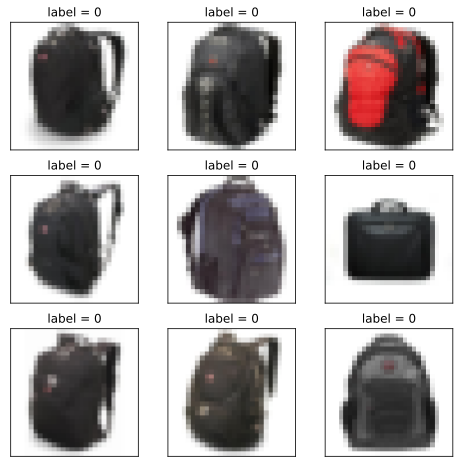

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = train_data[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [6]:
import torch.utils.data as data
from PIL import Image
import os


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data
    
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

valid_loader = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

## Define Model

In [9]:
class ReverseLayerF(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, num_classes))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

In [10]:
model = CNNModel().to(device)
# summary(model, input_size = [[channels, image_size, image_size], [1]], batch_size = batch_size)

In [11]:
model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.criterion = nn.NLLLoss()

## Train Model

In [12]:
def test(model, data_loader):
    #dropout layer stops working
    model.eval()
    
    len_loader = len(data_loader)
    data_iter = iter(data_loader)

    n_total = 0
    n_correct = 0

    for i in range(len_loader):
        img, label = data_iter.next()

        batch_size = len(label)

        img = img.to(device)
        label = label.to(device)

        class_output, _ = model(input_data = img, alpha = 0)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

    accu = n_correct.data.numpy() * 1.0 / n_total

    return accu


In [19]:
def train_model(model, epochs, train_loader, valid_loader, log_step_freq, model_save_path, epochs_to_save):
    
    dfhistory = pd.DataFrame(columns = ["epoch", "err_s_label", "err_s_domain", "err_t_domain", "err", "accu_s", "accu_t", "best_accu_s", "best_accu_t"])
    print("Start Training...")
#     nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#     print("=========="*8 + "%s"%nowtime)
    start_epoch = 1
    
    # load everything if existed
    if os.path.exists(model_save_path):
        checkpoint = torch.load(model_save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        dfhistory = checkpoint['dfhistory']
        start_epoch = int(dfhistory.loc[dfhistory.shape[0] - 1]['epoch']) + 1
        
    best_accu_t = 0.0
    best_accu_s = 0.0
    for epoch in range(start_epoch, epochs + 1): 
        len_loader = min(len(train_loader), len(valid_loader))
        data_source_iter = iter(train_loader)
        data_target_iter = iter(valid_loader)
        # 1，training loop-------------------------------------------------
        step = 0
        err_s_label = 0
        err_s_domain = 0
        err_t_domain = 0
        err = 0
        for step in range(len_loader):
            model.train()
            p = float(step + epoch * len_loader) / epochs / len_loader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            
            # training model using source data
            s_img, s_label = data_source_iter.next()

            model.zero_grad()
            batch_size = len(s_label)
            domain_label = torch.zeros(batch_size).long()

            s_img = s_img.to(device)
            s_label = s_label.to(device)
            domain_label = domain_label.to(device)

            class_output, domain_output = model(input_data = s_img, alpha = alpha)
            err_s_label = model.criterion(class_output, s_label)
            err_s_domain = model.criterion(domain_output, domain_label)

            # training model using target data
            t_img, _ = data_target_iter.next()

            batch_size = len(t_img)

            domain_label = torch.ones(batch_size).long()

            t_img = t_img.to(device)
            domain_label = domain_label.to(device)

            _, domain_output = model(input_data = t_img, alpha = alpha)
            err_t_domain = model.criterion(domain_output, domain_label)
            err = err_t_domain + err_s_domain + err_s_label
            err.backward()
            model.optimizer.step()
            sys.stdout.write('\r epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch, step + 1, len_loader, err_s_label.data.cpu().numpy(),
                 err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
            sys.stdout.flush()
            
        # 2，test-------------------------------------------------
        accu_s = test(model, train_loader)
        print('\nAccuracy of the source dataset: %f' % accu_s)
        accu_t = test(model, valid_loader)
        print('Accuracy of the target dataset: %f\n' % accu_t)
        if accu_t > best_accu_t:
            best_accu_s = accu_s
            best_accu_t = accu_t   

        # 3，logging-------------------------------------------------
        info = (epoch, err_s_label, err_s_domain, err_t_domain, err, accu_s, accu_t, best_accu_s, best_accu_t)
        dfhistory.loc[epoch - 1] = info
        
        if epoch > 1 and accu_t > dfhistory.loc[epoch - 2]["best_accu_t"]:
            torch.save(
                {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model.optimizer.state_dict(),
                    'dfhistory': dfhistory
                }, model_save_path) 
        
#         nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#         print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')

    return dfhistory

In [ ]:
dfhistory = train_model(model, epochs, train_loader, valid_loader, log_step_freq, model_save_path, epochs_to_save)

Start Training...
 epoch: 1, [iter: 461 / all 461], err_s_label: 0.139006, err_s_domain: 0.422309, err_t_domain: 0.393705Accuracy of the source dataset: 0.980583
Accuracy of the target dataset: 0.466687

 epoch: 2, [iter: 461 / all 461], err_s_label: 0.120238, err_s_domain: 0.479335, err_t_domain: 0.481063Accuracy of the source dataset: 0.985000
Accuracy of the target dataset: 0.548618

 epoch: 3, [iter: 461 / all 461], err_s_label: 0.177786, err_s_domain: 0.462074, err_t_domain: 0.457461Accuracy of the source dataset: 0.986917
Accuracy of the target dataset: 0.642820

 epoch: 4, [iter: 461 / all 461], err_s_label: 0.128003, err_s_domain: 0.524894, err_t_domain: 0.524794Accuracy of the source dataset: 0.986067
Accuracy of the target dataset: 0.673972

 epoch: 5, [iter: 461 / all 461], err_s_label: 0.139944, err_s_domain: 0.528990, err_t_domain: 0.639986Accuracy of the source dataset: 0.985117
Accuracy of the target dataset: 0.734920

 epoch: 6, [iter: 461 / all 461], err_s_label: 0.142

## Evaluate Model

In [21]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,2.930542,0.225946,3.369740,0.067212
1,2.0,2.834308,0.224027,3.413499,0.065848
2,3.0,2.750319,0.264529,3.324009,0.101521
3,4.0,2.668323,0.294031,3.298552,0.117973
4,5.0,2.573592,0.318462,3.333138,0.119378
5,6.0,2.482339,0.347245,3.289625,0.124132
6,7.0,2.381289,0.382641,3.265911,0.117725
7,8.0,2.275937,0.418209,3.252003,0.130828
8,9.0,2.148346,0.472451,3.284417,0.128886
9,10.0,2.034069,0.507333,3.242758,0.138641


In [22]:
%matplotlib inline
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

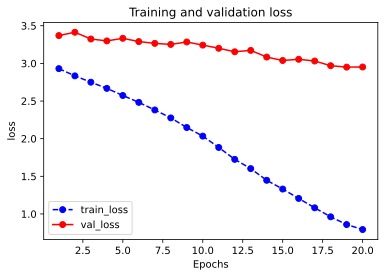

In [23]:
plot_metric(dfhistory, "loss")

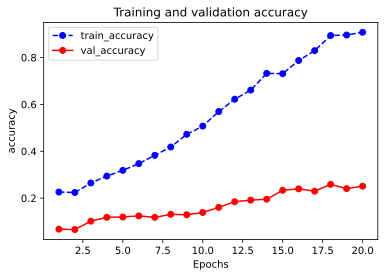

In [24]:
plot_metric(dfhistory, "accuracy")

## Use Model

In [28]:
def predict(model, test_loader):
    model.eval()
    result = torch.cat([model.forward(t[0].to(device)) for t in test_loader])
    return(result.data)

In [29]:
y_pred_probs = predict(model, valid_loader)
y_pred_probs

tensor([[ 0.3748,  4.8437,  1.4617,  ...,  2.8708,  0.6776, -0.5346],
        [-2.2492, -2.0688, -1.3195,  ..., -0.0474,  4.4492, -2.2328],
        [-1.5310,  0.1570, -1.5071,  ..., -2.2369,  0.1595, -2.6791],
        ...,
        [-0.5041, -0.0568,  3.7486,  ...,  0.0187, -0.7446,  0.7046],
        [ 0.4464,  1.0542, -1.8117,  ...,  3.4424, -1.0990,  4.4893],
        [-1.6516, -1.2160, -2.5498,  ..., -0.8564,  1.4545, -2.7748]],
       device='cuda:0')

In [30]:
y_pred = torch.where(y_pred_probs > 0.5,
        torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0')